In [266]:
import pandas as pd
import json
import random
import numpy as np

In [267]:
data = json.load(open("./data/hayday_tasks.json"))
source_name = data["machine"]
source_id = {}
for name in source_name:
    for machine_id in source_name[name]:
        source_id[machine_id] = name
num_machines = len(source_name)
tasks = data["tasks"][::-1]
num_tasks = len(tasks)
horizon = sum(task['duration'] for task in tasks)

In [268]:
# genetic algorithm
def gen_chromosome():
    """
    2D array of shape 2xN
    1nd row is the machine id
    2st row is the task id
    """
    chromosome = np.zeros((2, num_tasks), dtype=int)
    for i, task in enumerate(tasks):
        chromosome[0, i] = random.choice(task['machine'])
        chromosome[1, i] = task['id']
    return chromosome

In [269]:
def decode(chromosome):
    """
    Decode the chromosome to a schedule
    """
    # add these field to tasks: start_time, end_time, machine_id
    tasks = data["tasks"].copy()
    # to dict
    tasks = {task['id']: task for task in tasks}
    machine_queue = {machine_id: [] for machine_id in source_id}
    for i in range(num_tasks):
        task_id = chromosome[1, i]
        machine_id = chromosome[0, i]
        task = tasks[task_id]
        if len(machine_queue[machine_id]) == 0:
            start_time = 0
        else:
            last_task = machine_queue[machine_id][-1]
            start_time = last_task['end_time']
        task['start_time'] = start_time
        for dependent_task_id in task['dependent']:
            dependent_task = tasks[dependent_task_id]
            dependent_task_end_time = dependent_task['end_time']
            if dependent_task_end_time > start_time:
                start_time = dependent_task_end_time
        task['start_time'] = start_time
        task['end_time'] = start_time + task['duration']
        task['machine_id'] = machine_id
        machine_queue[machine_id].append(task)
    tasks = list(tasks.values())
    df = pd.DataFrame(tasks)
    df.set_index('id', inplace=True)
    df['machine_id']=df['machine_id'].astype(str)
    return df

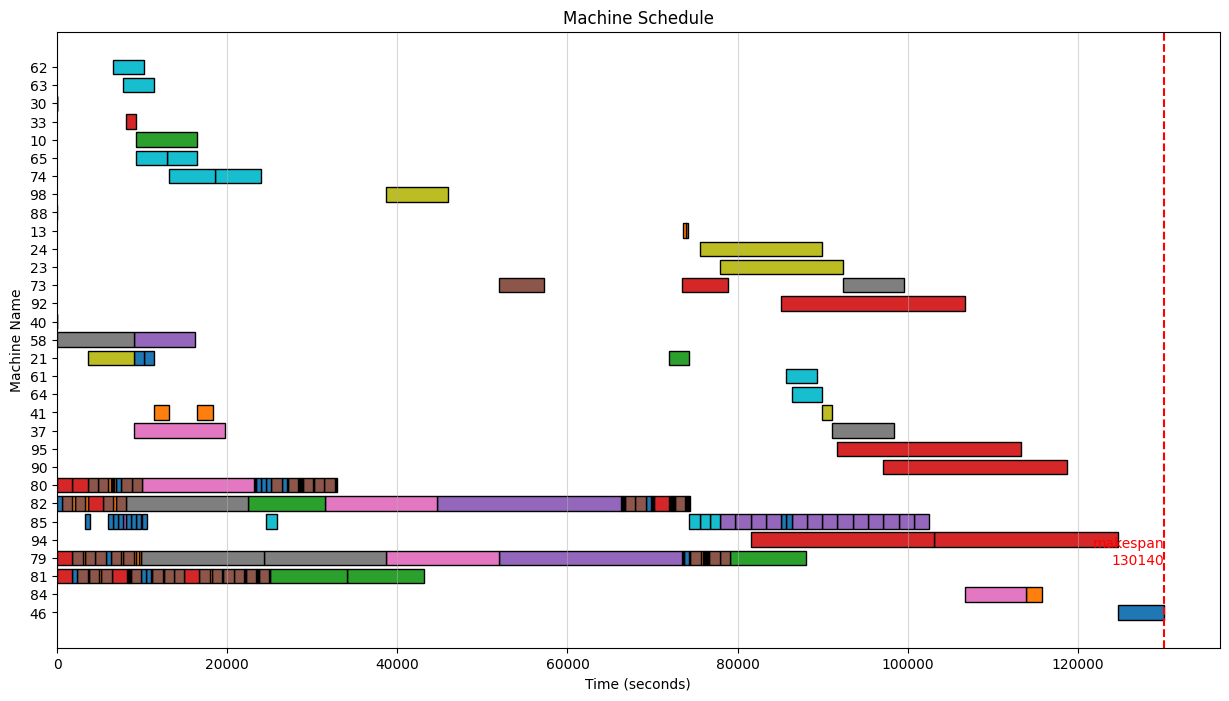

In [270]:
import seaborn as sns
import matplotlib.pyplot as plt

chromosome = gen_chromosome()
df = decode(chromosome)

fig, ax = plt.subplots(figsize=(15, 8))
# random colors
colors = sns.color_palette(None, n_colors=len(df['name'].unique()))
colors = {name:  color for name, color in zip(df['name'].unique(), colors)}

for i, job_id in enumerate(df['job_id'].unique()):
    df_job = df[df['job_id'] == job_id]
    for i, row in df_job.iterrows():
        ax.barh(row['machine_id'], width=row['end_time']-row['start_time'], left=row['start_time'], 
                color=colors[row['name']],
                edgecolor='black',
                )
        # ax.text(x=(row['start']+row['end'])/2, y=row['machine'],
        #          s=row['task_name'], color='black',
        #          verticalalignment='center', horizontalalignment='center',
        #          )
plt.title('Machine Schedule')
plt.xlabel('Time (seconds)')
plt.ylabel('Machine Name')
plt.yticks(df['machine_id'].unique())
ax.xaxis.grid(True, alpha=0.5)

ax.axvline(x=max(df['end_time']), color='r', linestyle='--')
makespan = max(df['end_time'])
ax.text(x=makespan-10, y=2.5, s=f'makespan\n{makespan}', color='r', verticalalignment='bottom', horizontalalignment='right')

plt.show()